In [1]:
import mxnet as mx
import gluonnlp as nlp
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set Context (change to cpu if no gpu available)
# ctx = mx.cpu()
ctx = mx.gpu()

# Local Libraries
# Load Model locally
import textcnn
# Load helper functions
import utils

[nltk_data] Downloading package punkt to /home/andres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
w2v = nlp.embedding.Word2Vec()

In [ ]:
nlp.embedding.list_sources('Word2Vec')

In [ ]:
embed_size = len(w2v["man"])
print(embed_size)

In [ ]:
# References

# Loading data for NLP
# https://nlp.gluon.ai/api/notes/data_api.html

# TextCNN from D2L
# https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html

# d2l: Load data IMDB
# https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-and-dataset.html

# Handling strings in dataloader
# https://stackoverflow.com/questions/56755384/mxnet-ndarray-with-dtype-string

# TextCNN with Keras
# https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7

# https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
# https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb#scrollTo=9X_4ticSpxUC

In [ ]:
# Loading the dataset
full_train_dataset, test_dataset = [nlp.data.IMDB(root='data/imdb', segment=segment)
                               for segment in ('train', 'test')]

# Dataset Sizes
print("Size of Train Set:", len(full_train_dataset), " (no valid split yet)")
print("Size of Test  Set:", len(test_dataset))

# # Filtering for size
# full_train_dataset = full_train_dataset[:6250]
# test_dataset = test_dataset[:1250]
# print("Size of Train Set (Post-filter):", len(full_train_dataset), " (no valid split yet)")
# print("Size of Test  Set (Post-filter):", len(test_dataset))

In [ ]:
print(test_dataset[0][0])
sequence_test = utils.process_words(utils.clean_text(test_dataset[0][0]))
print(sequence_test)

In [ ]:
# Dataset Split 40/10/50
# Test dataset at 50% is given by library, validation dataset is 20% of train dataset
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(full_train_dataset, test_size=int(0.2*len(full_train_dataset)), random_state=42)

In [ ]:
# Final Dataset Sizes
print("Size of Train Set:", len(train_dataset))
print("Size of Val   Set:", len(val_dataset))
print("Size of Test  Set:", len(test_dataset))

In [ ]:
# Each input in a batch, needs to have the same length
# We need to apply a batchify function to pad with zeros (if necessary)
# On the output, we just stack them together to get a batch-size array
batchify_fn = nlp.data.batchify.Tuple(nlp.data.batchify.Pad(axis=1, pad_val=0),
                                      nlp.data.batchify.Stack())

In [ ]:
from importlib import reload
reload(textcnn)

# CNN with 3 parallel filters
text_cnn = textcnn.TextCNN([3, 4, 5], [embed_size, embed_size, embed_size])
text_cnn.initialize(mx.init.MSRAPrelu(), ctx)

# Formatting single input as expected for the network
direct_embeddings_test = w2v[sequence_test]
direct_embeddings_reshaped_test = direct_embeddings_test.transpose()
# Transform it into a batch of size 1
direct_embeddings_reshaped_test = mx.nd.expand_dims(direct_embeddings_reshaped_test, axis = 0)
final_embeddings_test = direct_embeddings_reshaped_test.as_in_context(ctx)

print(direct_embeddings_reshaped_test.shape)

text_cnn.summary(final_embeddings_test)

In [ ]:
review_sentiment = text_cnn(final_embeddings_test)
# We can omit sigmoid processing, outputs of the network
# with positive values are positive reviews
if review_sentiment >= 0:
    print(review_sentiment, "The review is positive")
else:
    print(review_sentiment, "The review is negative")

In [17]:
# Dataset processing
train_set = []
for review, score in train_dataset:
    # Processing inputs & applying embeddings
    processed_review = utils.process_words(utils.clean_text(review))
    embeddings = w2v[processed_review].transpose()
    
    # A negative review has a score <= 4
    # A positive review has a score >= 7 out of 10
    sentiment = int(score > 5)
    train_set.append((embeddings, sentiment))

In [18]:
val_set = []
for review, score in val_dataset:
    # Processing inputs & applying embeddings
    processed_review = utils.process_words(utils.clean_text(review))
    embeddings = w2v[processed_review].transpose()
    
    # A negative review has a score <= 4
    # A positive review has a score >= 7 out of 10
    sentiment = int(score > 5)
    val_set.append((embeddings, sentiment))

In [19]:
epochs = 5
batch_size = 4

model_file_name = "w2v_textcnn.params"

loss_fn = mx.gluon.loss.SigmoidBCELoss()
trainer = mx.gluon.Trainer(text_cnn.collect_params(), "adam", {"learning_rate": 0.001})

training_loss, validation_loss, validation_acc = text_cnn.train(
    loss_fn,
    trainer,
    epochs,
    batch_size,
    train_set,
    val_set,  
    batchify_fn,
    ctx,
    model_file_name)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/andres/.local/lib/python3.8/site-packages/gluonnlp/data/batchify/batchify.py:268: UserWarning: Using Pad with NDArrays is discouraged for speed reasons. Instead you should pad your data while it is still a list and before converting to an NDArray. Alternatively you can consider inputting a numpy.ndarray.
  warnings.warn(
[10:55:19] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[10:55:20] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[10:55:21] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm,

E:    0, TrL: 0.445796, VL: 0.393460, VAcc: 0.814000 --- Updating saved model


 40%|██████████████████                           | 2/5 [01:42<02:30, 50.13s/it]

E:    1, TrL: 0.339468, VL: 0.343387, VAcc: 0.850400 --- Updating saved model


 60%|███████████████████████████                  | 3/5 [02:28<01:36, 48.43s/it]

E:    2, TrL: 0.269836, VL: 0.355075, VAcc: 0.850400


 80%|████████████████████████████████████         | 4/5 [03:13<00:47, 47.19s/it]

E:    3, TrL: 0.206903, VL: 0.329245, VAcc: 0.866200 --- Updating saved model


100%|█████████████████████████████████████████████| 5/5 [04:00<00:00, 48.00s/it]

E:    4, TrL: 0.153115, VL: 0.368850, VAcc: 0.860000


In [20]:
review_sentiment = text_cnn(final_embeddings_test)
# We can omit sigmoid processing, outputs of the network
# with positive values are positive reviews
if review_sentiment >= 0:
    print(review_sentiment, "The review is positive")
else:
    print(review_sentiment, "The review is negative")

[[-1.0106202]] @gpu(0) The review is negative


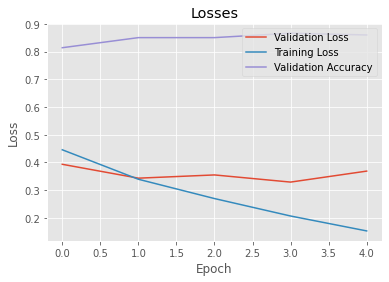

In [21]:
# plot losses and validation accuracy
epochs = 5

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.plot(np.arange(0, epochs), validation_acc[:epochs], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.show()

In [ ]:
# Quantitative Evaluation on Test Set
test_set = []

# Limiting test set size to 5000 samples for memory constrains
# It is encouraged to increase this value up to 25000 (actual size of test set)
# if your memory permits
for review, score in test_dataset[:5000]:
    # Processing inputs & applying embeddings
    processed_review = utils.process_words(utils.clean_text(review))
    embeddings = w2v[processed_review].transpose()
    
    # A negative review has a score <= 4
    # A positive review has a score >= 7 out of 10
    sentiment = int(score > 5)
    test_set.append((embeddings, sentiment))

In [24]:
# Processing Test dataset for confussion matrix
num_test_batches = len(test_set) / batch_size

# Iterator on Test dataset
test_data_iterator = mx.gluon.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    batchify_fn=batchify_fn)

In [25]:
# Confussion Matrix Computation (Test set)
class_outputs = mx.nd.empty(shape=(len(test_set),))
labels = mx.nd.empty(shape=(len(test_set),))

test_acc = mx.metric.Accuracy()
cumulative_test_loss = 0

for index, (data, label) in enumerate(tqdm(test_data_iterator)):
    
    # Add labels for Confussion Matrix
    labels[index * batch_size:(index + 1) * batch_size] = label
                
    # Processing data from data iterator
    data_np = data.as_np_ndarray().as_in_context(ctx)
    label_np = label.as_np_ndarray().as_in_context(ctx)

    output_np = text_cnn(data_np)
    test_loss = loss_fn(output_np, label_np)
    current_test_loss = mx.np.mean(test_loss)
    cumulative_test_loss += current_test_loss / num_test_batches

    # Accuracy
    # Comparison between  labels and values output
    # Applying threshold for binary classification
    # No sigmoid necessary as outputs of the network
    # with positive values are positive reviews
    class_output = (output_np.as_nd_ndarray() >= 0).astype("uint8").transpose()
    class_outputs[index * batch_size:(index + 1) * batch_size] = class_output
    test_acc.update(label.as_in_context(ctx), class_output[0])

test_acc_value = test_acc.get()[1]
print("Final Test Accuracy:", test_acc_value)

100%|█████████████████████████████████████████| 313/313 [00:05<00:00, 53.60it/s]

Final Test Accuracy: 1.0


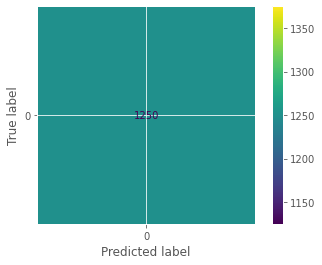

In [26]:
# Plot the CM
confusion_matrix = metrics.confusion_matrix(labels.asnumpy(), class_outputs.asnumpy())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot()